In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from GPyEm import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

seed = 7
#set_seed(seed)

# User input: choose mesh

In [2]:
mesh=51

Load data

In [3]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

       CV_f_v  ani_ratio_v    k_FEC    CV_f_a  ani_ratio_a     k_BB
0    0.606444     0.442714  5.53288  0.317814     0.376440  1.35358
1    0.518476     0.304389  6.83032  0.628421     0.237364  1.25791
2    0.641101     0.239081  5.82181  1.020680     0.437033  5.30559
3    0.750099     0.373713  4.49537  0.526532     0.444927  2.07317
4    0.689263     0.388615  2.34609  0.556797     0.477035  2.36587
..        ...          ...      ...       ...          ...      ...
115  0.545148     0.260282  1.41140  0.982380     0.242211  2.02864
116  0.407284     0.272427  1.55631  0.353259     0.340049  1.65963
117  0.796166     0.465371  7.16628  0.539272     0.228129  1.68568
118  0.752534     0.476168  3.40841  0.386740     0.264407  5.40274
119  0.687991     0.318799  6.32706  0.767307     0.234231  4.38626

[120 rows x 6 columns]


In [4]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

        A_TAT     V_TAT
0    364.8160  113.1400
1    200.2980  153.0220
2     96.8148  135.4560
3    202.4910   97.5508
4    185.0300  105.1280
..        ...       ...
115  115.0130  171.7860
116  333.9810  219.1650
117  199.5290   84.5688
118  224.6100   89.0703
119  124.2760  113.3090

[120 rows x 2 columns]


# Emulator

Convert pandas to torch

In [5]:
y_train = torch.tensor(y_all.values)
# Choose appropriate values from X_all (if X_all bigger than y_all)
x_train = torch.tensor(X_all[0:y_all.shape[0]].values) 

In [6]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500) #Train emulator

0
1


In [7]:
input_masked=X_all
# Generate max and min bounds
nDim =input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.382351, 0.799717]
[0.201679, 0.499831]
[1.24091, 8.38479]
[0.300623, 1.02851]
[0.200837, 0.497599]
[1.01838, 5.67135]


In [8]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_9680/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [9]:
data1.shape

torch.Size([14336, 6])

In [10]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                      ST   ST_conf
(CV_f_v,)       0.000015  0.000003
(ani_ratio_v,)  0.013204  0.001209
(k_FEC,)        0.000058  0.000010
(CV_f_a,)       0.923668  0.067031
(ani_ratio_a,)  0.000022  0.000003
(k_BB,)         0.071158  0.007112
                      S1   S1_conf
(CV_f_v,)      -0.000035  0.000287
(ani_ratio_v,)  0.011783  0.009944
(k_FEC,)        0.000035  0.000720
(CV_f_a,)       0.914419  0.081895
(ani_ratio_a,) -0.000268  0.000432
(k_BB,)         0.065608  0.024470
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                      ST   ST_conf
(CV_f_v,)       0.813633  0.067315
(ani_ratio_v,)  0.167276  0.015342
(k_FEC,)        0.027898  0.004723
(CV_f_a,)       0.000057  0.000010
(ani_ratio_a,)  0.000414  0.000114
(k_BB,)         0.000080  0.000014
                      S1   S1_conf
(CV_f_v,)       0.807260  0.071612
(ani_ratio_v,)  0.159420  0.036923
(k_FEC,)        0.024783  0.015237
(CV_f_a,)      -0.000211  0.000576
(ani_ratio_a,)  0.000729  0.001601
(k_BB,

In [11]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


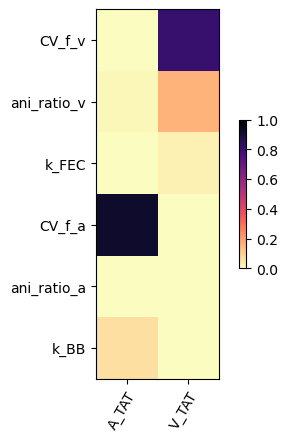

In [12]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

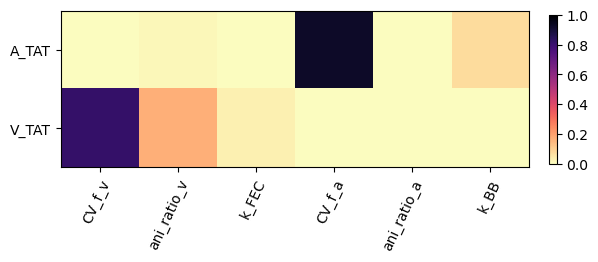

In [13]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [14]:
np.savetxt("Si_total_EP_"+str(mesh)+".csv", Si_total, delimiter=",")
np.savetxt("Si_first_EP_"+str(mesh)+".csv", Si_first, delimiter=",")